![logo](./img/LogoLine_horizon_CAMS.png)

# Plot Time Series of CAMS Data

This tutorial demonstrates how to plot time series of data from the [Copernicus Atmosphere Monitoring Service (CAMS)](https://atmosphere.copernicus.eu/). The example focusses on CO2, and we will visualise the "Keeling Curve" of global average increases in CO2 from the last decades.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-time-series.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-time-series.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-time-series.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br>

## Install and import packages

In [ ]:
!pip install cdsapi

In [2]:
# CDS API
import cdsapi

# Libraries for reading and working with multidimensional arrays
import numpy as np
import xarray as xr

# Library for plotting and visualising data
%matplotlib inline
import matplotlib.pyplot as plt

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Data access and preprocessing

### Download CAMS global reanalysis data

Copy your API key into the code cell below, replacing `#######` with your key. (Remember, to access data from the ADS, you will need first to register/login https://ads.atmosphere.copernicus.eu/ and obtain an API key from https://ads.atmosphere.copernicus.eu/how-to-api.)

In [3]:
URL = 'https://ads.atmosphere.copernicus.eu/api'

# Replace the hashtags with your key:
KEY = '##################################'

Here we specify a data directory into which we will download our data and all output files that we will generate:

In [4]:
DATADIR = '.'

For this tutorial, we will use *CAMS global greenhouse gas reanalysis (EGG4)* data, monthly averaged fields version. The code below shows the subset characteristics that we will extract from this dataset as an API request.

```{note}
Before running this code, ensure that you have **accepted the terms and conditions**. This is something you only need to do once for each CAMS dataset. You will find the option to do this by selecting the dataset in the ADS, then scrolling to the end of the *Download data* tab.
```

In [5]:
dataset = "cams-global-ghg-reanalysis-egg4-monthly"
request = {
    'variable': ['co2_column_mean_molar_fraction'],
    'year': ['2003', '2004', '2005', '2006', 
             '2007', '2008', '2009', '2010', 
             '2011', '2012', '2013', '2014', 
             '2015', '2016', '2017', '2018', 
             '2019', '2020'],
    'month': ['01', '02', '03', '04', '05', '06', 
              '07', '08', '09', '10', '11', '12'],
    'product_type': ['monthly_mean'],
    'data_format': 'netcdf'
}

client = cdsapi.Client(url=URL, key=KEY)
client.retrieve(dataset, request).download(
    f'{DATADIR}/CO2_2003-2020.nc')

2024-09-12 14:14:30,224 INFO Request ID is f2070345-f2f8-46ea-9638-96715107bffd
2024-09-12 14:14:30,375 INFO status has been updated to accepted
2024-09-12 14:14:32,030 INFO status has been updated to running
2024-09-12 14:14:50,916 INFO Creating download object as as_source with files:
['data_allhours_sfc.nc']
2024-09-12 14:14:50,917 INFO status has been updated to successful


5245c36ce942f9848218193a0bf40472.nc:   0%|          | 0.00/42.3M [00:00<?, ?B/s]

'./CO2_2003-2020.nc'

### Read and inspect data

Read the data into an Xarray dataset:

In [6]:
fn = f'{DATADIR}/CO2_2003-2020.nc'
ds = xr.open_dataset(fn)
ds

<xarray.Dataset> Size: 100MB
Dimensions:     (valid_time: 216, latitude: 241, longitude: 480)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2003-01-01 ... 2020-12-01
  * latitude    (latitude) float64 2kB 90.0 89.25 88.5 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 4kB 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
Data variables:
    tcco2       (valid_time, latitude, longitude) float32 100MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-12T14:14 GRIB to CDM+CF via cfgrib-0.9.1...

### Spatial aggregation

We would like to visualise this data not in maps, but as a one dimensional time series of global average values. To do this, we will first need to aggregate the data spatially to create a single global average at each time step.

In order to aggregate over the latitudinal dimension, we need to take into account the variation in area as a function of latitude. We will do this using the cosine of the latitude as a proxy:

In [7]:
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"
ds_weighted = ds.weighted(weights)

Now we can average over both the longitude and latitude dimensions:

In [8]:
# Average (mean) over the latitudinal axis
co_ds = ds_weighted.mean(dim=["latitude", "longitude"])

### Create xarray Data Array from Dataset object

Here we create an Xarray Data Array object containing the CO2 variable.

In [9]:
co = co_ds['tcco2']

## Plot time series of global CO

Now we can plot the time series of globally averaged CO2 data over time.

### Simple plot using xarray

The easiest way to plot data in an Xarray Data Array object is to use Xarray's own plotting functionality.

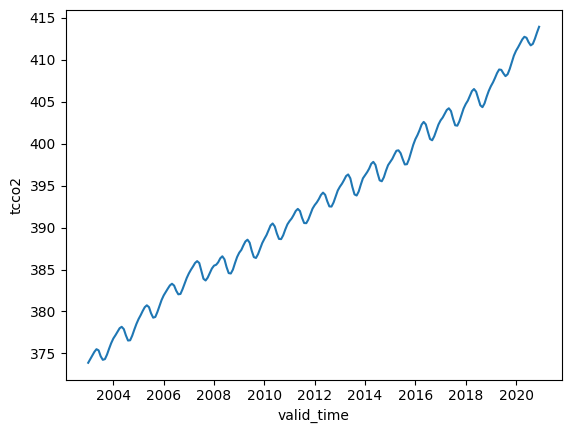

In [10]:
co.plot()

In this plot of monthly averaged CO2 we can see the seasonal variation and yearly increase in global CO2 over the last decades.

### Customised plot using matplotlib

In this example we use the Matplotlib library to create the same plot as above, with a few customisations

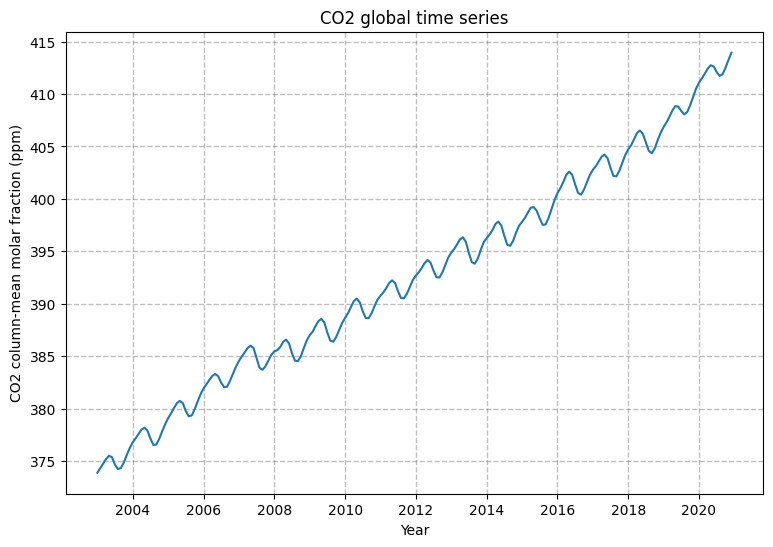

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (9, 6)) # Set size and dimensions of figure

ax.set_title('CO2 global time series', fontsize=12) # Set figure title
ax.set_ylabel('CO2 column-mean molar fraction (ppm)') # Set Y axis title
ax.set_xlabel('Year') # Set X axis title
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--') # Include gridlines
ax.plot(co.valid_time, co) # Plot the data

fig.savefig(f'{DATADIR}/CAMS_CO2_reanalysis.png') # Save the figure